<a href="https://colab.research.google.com/github/merttezcan/Next-Level-Clickbait-Detection-System-using-Machine-Learning-Deep-Learning-Techniques/blob/main/Clickbait_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Next-Level Clickbait Detection System using Machine Learning & Deep Learning Techniques

#### Author: Mehmet Mert Tezcan

# 1. Introduction

In today's fast-paced digital media landscape, clickbait headlines have become a common tactic used by news organizations to drive traffic to their websites. These sensationalized or misleading headlines are designed to grab the reader's attention and entice them to click on a link to an article or website. While clickbait can be profitable for the website, it can also be frustrating and misleading for readers.

This project aims to address the issue of clickbait in the news industry by developing a system for detecting clickbait headlines in a dataset of Turkish news articles. By identifying and flagging clickbait headlines, we hope to improve the quality and trustworthiness of online news for readers. Additionally, this project aims to contribute to the ongoing conversation about the impact of clickbait on the credibility of the news media and the role of technology in combating it.

# 2. Characterizing the Turkish News Dataset

Our dataset for this project consists of 20,036 headlines, each labeled as either clickbait (1) or non-clickbait (0). These headlines were collected from a variety of websites and are available for download on [Kaggle](https://www.kaggle.com/datasets/suleymancan/turkishnewstitle20000clickbaitclassified).

In order to build a reliable clickbait detection system, it is important to have a diverse and representative dataset. This dataset provides a good starting point, but it is worth noting that it may not perfectly reflect the full range of clickbait practices in the Turkish news industry. Further analysis and preprocessing of the dataset may be necessary to ensure that it is well-suited for the task at hand.

# 3. Let's start with the code

## 3.1 Importing Libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

import re
import string
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3.2 Importing data

- The dataset is loaded into a pandas dataframe using the read_csv() function. Shape is used to display the number of rows and columns in the dataframe. We can also check value.counts() to see how many headlines are labeled as clickbait and how many are labeled as non-clickbait.

- The first five rows of the dataframe are displayed using the head() function.

In [2]:
df = pd.read_csv('20000_turkish_news_title.csv')
print("Shape of the dataset:", df.shape)

print("Number of the clickbait and non-clickbait titles:")
print(df.clickbait.value_counts())

Shape of the dataset: (20038, 4)
Number of the clickbait and non-clickbait titles:
1.0    10030
0.0    10006
Name: clickbait, dtype: int64


In [3]:
df.head()

,id,clickbait,site,title
0,25892,1.0,hurriyet.com.tr,İhracatta Türkiye'nin yarısını geçti
1,25893,1.0,hurriyet.com.tr,Borsa İstanbul günü düşüşle tamamladı
2,25894,1.0,hurriyet.com.tr,Londra ve Manchester uçuşlarında yolcu rekoru ...
3,4,0.0,nayn.co,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...
4,5,0.0,nayn.co,Vatandaşın derdine ortak olmaya soyunan bir cu...


## 3.3 Data preprocessing

Before we can begin analyzing the data, we need to perform some preprocessing steps to get it into a form that is suitable for our purposes. The dataset consists of four columns: "id", "clickbait", "site", and "title". The "id" column is a unique identifier for each headline, the "clickbait" column is the label (either 1 for clickbait or 0 for non-clickbait), the "site" column is the website where the headline was published, and the "title" column is the headline text.

For the purposes of this project, we are only interested in the "clickbait" and "title" columns, as the "clickbait" column provides the labels for our data and the "title" column contains the text that we will be analyzing. The "id" and "site" columns are not relevant for our analysis, so we can drop them from the dataset.

Also we can rename the "clickbait" column to "label".

In [4]:
df = df.drop(df.columns[[0, 2]],axis = 1)
df = df.rename(columns = {'clickbait':'label'})

df

,label,title
0,1.0,İhracatta Türkiye'nin yarısını geçti
1,1.0,Borsa İstanbul günü düşüşle tamamladı
2,1.0,Londra ve Manchester uçuşlarında yolcu rekoru ...
3,0.0,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...
4,0.0,Vatandaşın derdine ortak olmaya soyunan bir cu...
...,...,...
20033,1.0,"Kılıçdaroğlu, 8 Mart Dünya Emekçi Kadınlar Gün..."
20034,1.0,Abdest nasıl alınır? Abdest alırken hangi dual...
20035,1.0,"Sıla Hanım, Ahmet Bey’in inançlarına saygısızmış!"
20036,1.0,Binali Yıldırım: Hiçbir şekilde hakkınızın kay...


Before we can proceed with our analysis, it is important to ensure that the data is clean and free of errors or missing values. Missing data can introduce biases and distort our results, so it is important to identify and handle missing values appropriately.

One way to check for missing values is to use the .isnull() function, which returns a Boolean mask indicating which values are missing. We can then use the .sum() function to count the number of missing values per column. In the case of our dataset, we can use these functions to check for missing values as follows:

In [5]:
null_mask = df.isnull()
null_counts = null_mask.sum()
print(null_counts)

label    2
title    0
dtype: int64


We only have two missing values in our dataset. We can drop them.

In [6]:
df = df.dropna()

# 4. Feature Engineering

One way to extract meaningful information from text data is to use feature engineering techniques. Feature engineering involves creating new features from the raw data that capture important patterns or trends. These features can then be used as input to machine learning algorithms, which can learn to identify patterns in the data and make predictions or decisions based on those patterns.

In the case of our clickbait detection project, the "title" column contains the headline text that we want to analyze. One potential feature that we might extract from this text is the presence or absence of certain punctuation marks. For example, we could create two new binary features named contains_exclamation and contains_question_mark that indicate whether a headline contains an exclamation mark or a question mark, respectively. These features might be useful for detecting clickbait headlines, as sensational headlines often contain exclamation marks or question marks to grab the reader's attention.

We can also consider more advanced features that capture the linguistic structure of the headline. Other potential features can be the title length, presence of numbers, uppercase letters, or the presence of sentiment words, such as "amazing" or "shocking" (in Turkish). Clickbait headlines often use emotionally charged language to create a sense of urgency or excitement.

To extract these features, we can use regular expressions (with the re library) to search the headline text for exclamation marks and question marks. If either punctuation mark is present, we can set the corresponding feature to 1, and if not, we can set it to 0. This process can be done using the following code:

In [7]:
def extract_features(text):
    contains_exclamation = int('!' in text)
    contains_question_mark = int('?' in text)
    # length of the title
    title_length = int(len(text))
    
    # number of words in the title
    num_of_words = int(len(text.split()))
    
    # number of uppercase letters in the title
    num_of_uppercase_letters= int(sum(1 for c in text if c.isupper()))

    # presence of numbers in the title
    presence_of_numbers = int(bool(re.search(r'\d', text)))
    
    # presence of words that they use for clickbaits usually
    clickbait_words = ["son dakika", "flaş", "müjde", "inanamayacaksınız"]
    clickbait_words_count = int(sum(1 for word in clickbait_words if word in text.lower()))

    return [contains_exclamation, contains_question_mark, title_length, num_of_words, num_of_uppercase_letters, presence_of_numbers, clickbait_words_count]

features = []
for text in df['title']:
    features.append(extract_features(text))


# add features to the dataframe

df['contains_exclamation'] = [f[0] for f in features]
df['contains_question_mark'] = [f[1] for f in features]
df['title_length'] = [f[2] for f in features]
df['num_of_words'] = [f[3] for f in features]
df['num_of_uppercase_letters'] = [f[4] for f in features]
df['presence_of_numbers'] = [f[5] for f in features]
df['clickbait_words_count'] = [f[6] for f in features]

df.head()


,label,title,contains_exclamation,contains_question_mark,title_length,num_of_words,num_of_uppercase_letters,presence_of_numbers,clickbait_words_count
0,1.0,İhracatta Türkiye'nin yarısını geçti,0,0,36,4,2,0,0
1,1.0,Borsa İstanbul günü düşüşle tamamladı,0,0,37,5,2,0,0
2,1.0,Londra ve Manchester uçuşlarında yolcu rekoru ...,0,0,53,7,2,0,0
3,0.0,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...,0,0,114,13,5,1,0
4,0.0,Vatandaşın derdine ortak olmaya soyunan bir cu...,0,0,88,11,1,0,0


Now we need to do further preprocessing, we are doing it especially after the feature engineering part since we are going to lose some of the punctuations now.

Before we can use the headline text for analysis, it is often necessary to preprocess the text to remove noise and make it more amenable to analysis. This preprocessing step can involve a variety of tasks, such as lowercasing the text, removing punctuation and non-alphabetic characters, and stemming (reducing words to their base form).

To remove punctuation and non-alphabetic characters from the headline text, we can use the string library and a regular expression (with the re library) to replace these characters. Also a further specific work has been done for the special characters in Turkish. 

In [8]:
def preprocess_text(text):

    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('“','',text)
    text = re.sub('”','',text)
    text = re.sub('’','',text)
    text = re.sub('–','',text)
    text = re.sub('‘','',text)

    # remove punctuation
    text = ''.join([c for c in text if c not in punctuation])

    # replace special turkish characters
    text = re.sub(r"Â", "A", text)
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    # make text lowercase and take care of the special character 'ı'
    text = re.sub(r"I", "ı", text)
    text = text.lower()

    # make text lowercase and take care of the special character 'İ'
    text = re.sub(r"İ", "i", text)
    text = text.lower()

    # remove new line characters
    text = re.sub(r"\n", "  ", text)
    text = re.sub(r"  ", " ", text)
    
    return text

preprocessed_text = []
for text in df['title']:
    preprocessed_text.append(preprocess_text(text))

df['title'] = preprocessed_text
df.head()

,label,title,contains_exclamation,contains_question_mark,title_length,num_of_words,num_of_uppercase_letters,presence_of_numbers,clickbait_words_count
0,1.0,i̇hracatta türkiyenin yarısını geçti,0,0,36,4,2,0,0
1,1.0,borsa i̇stanbul günü düşüşle tamamladı,0,0,37,5,2,0,0
2,1.0,londra ve manchester uçuşlarında yolcu rekoru ...,0,0,53,7,2,0,0
3,0.0,chpli i̇lgezdiden partisine ve kılıçdaroğluna ...,0,0,114,13,5,1,0
4,0.0,vatandaşın derdine ortak olmaya soyunan bir cu...,0,0,88,11,1,0,0


This will leave us with a list of preprocessed headlines that are all lowercase, contain only alphabetic characters, and do not contain any punctuation or non-alphabetic characters. We can then use this preprocessed text as input to our machine learning model or for other analysis tasks.

Lastly, we can put the label column at the end of the dataset for better visualization.

In [9]:
cols = list(df.columns.values)
cols.pop(cols.index('label'))
df = df[cols+['label']]
df

,title,contains_exclamation,contains_question_mark,title_length,num_of_words,num_of_uppercase_letters,presence_of_numbers,clickbait_words_count,label
0,i̇hracatta türkiyenin yarısını geçti,0,0,36,4,2,0,0,1.0
1,borsa i̇stanbul günü düşüşle tamamladı,0,0,37,5,2,0,0,1.0
2,londra ve manchester uçuşlarında yolcu rekoru ...,0,0,53,7,2,0,0,1.0
3,chpli i̇lgezdiden partisine ve kılıçdaroğluna ...,0,0,114,13,5,1,0,0.0
4,vatandaşın derdine ortak olmaya soyunan bir cu...,0,0,88,11,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...
20033,kılıçdaroğlu 8 mart dünya emekçi kadınlar günü...,0,0,69,9,7,1,0,1.0
20034,abdest nasıl alınır abdest alırken hangi duala...,0,1,61,8,2,0,0,1.0
20035,sıla hanım ahmet beyin inançlarına saygısızmış,1,0,49,6,4,0,0,1.0
20036,binali yıldırım hiçbir şekilde hakkınızın kayb...,0,0,73,8,3,0,0,1.0


# 5. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an approach to analyzing data that is focused on understanding the patterns and relationships in the data, and identifying any potential biases or anomalies. EDA is typically an iterative process, in which the analyst repeatedly examines the data, generates hypotheses, and tests those hypotheses using statistical techniques or visualizations.

The goal of EDA is to gain a deeper understanding of the data and to identify any interesting or unexpected patterns that might be worth further investigation. This understanding can then inform the development of machine learning models or other analysis tasks.

In the context of this clickbait detection project, EDA might involve examining the distribution of clickbait and non-clickbait headlines in the dataset, looking for any patterns or trends that might be correlated with clickbait status. It might also involve exploring the characteristics of the headline text, such as the length of the headlines, the presence or absence of certain words or phrases, or the use of certain punctuation marks. By doing EDA, we can gain insights into the properties of the data that might be useful for building an effective clickbait detection system.

## 5.1 Distribution of Clickbait and Non-Clickbait Headlines

One simple way to do this is to use a histogram or bar plot to visualize the counts of clickbait and non-clickbait headlines. This can give us a sense of the overall balance of the dataset and whether there are any imbalances that might need to be addressed.

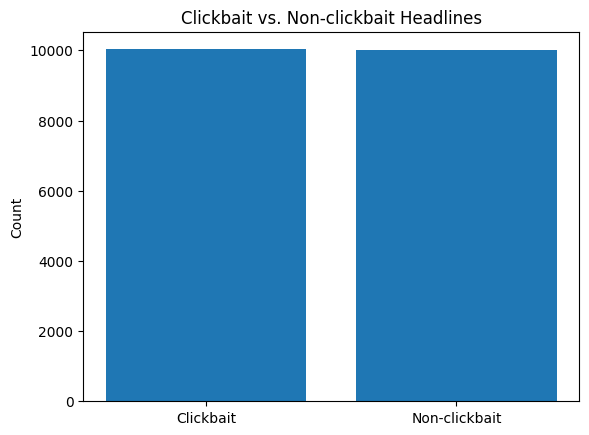

In [10]:
# Count the number of clickbait and non-clickbait headlines
clickbait_count = df[df['label'] == 1].shape[0]
non_clickbait_count = df[df['label'] == 0].shape[0]

# Set the labels and data for the bar plot
labels = ['Clickbait', 'Non-clickbait']
data = [clickbait_count, non_clickbait_count]

# Create the bar plot
plt.bar(labels, data)
plt.title('Clickbait vs. Non-clickbait Headlines')
plt.ylabel('Count')

# Show the plot
plt.show()

We can say that the dataset is well distributed and there is no imbalance.

## 5.2 Distribution of Number of Words

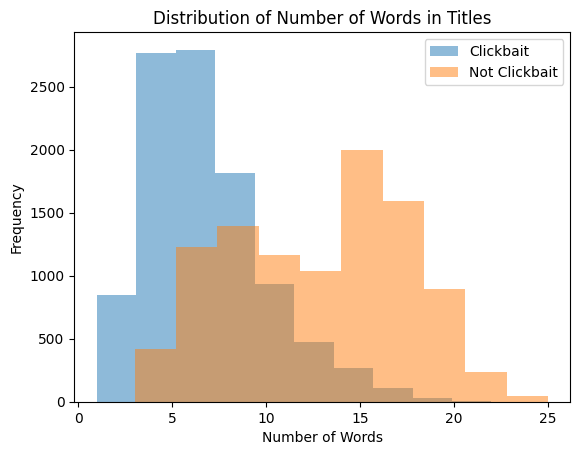

In [11]:
# Separate data based on labels
clickbait = df[df['label'] == 1]
not_clickbait = df[df['label'] == 0]

# Plot histograms of num_of_words feature for clickbait and not_clickbait
plt.hist(clickbait['num_of_words'], alpha=0.5, label='Clickbait')
plt.hist(not_clickbait['num_of_words'], alpha=0.5, label='Not Clickbait')

# Add labels and legend
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Titles')
plt.legend(loc='upper right')

# Show plot
plt.show()


This plot shows the distribution of the number of words in the titles of clickbait and non-clickbait articles. The x-axis represents the number of words, while the y-axis represents the frequency or count of titles that have a certain number of words. The blue histogram shows the distribution of number of words in clickbait titles, and the orange histogram shows the distribution of number of words in non-clickbait titles. 

This plot suggests us that clickbait titles tend to have less words on average compared to non-clickbait titles.

## 5.3 Distribution of Title Length

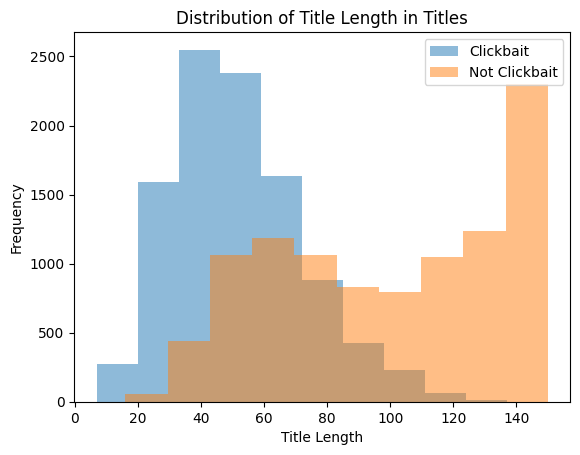

In [12]:
# Plot histograms of title_length feature for clickbait and not_clickbait
plt.hist(clickbait['title_length'], alpha=0.5, label='Clickbait')
plt.hist(not_clickbait['title_length'], alpha=0.5, label='Not Clickbait')

# Add labels and legend
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Distribution of Title Length in Titles')
plt.legend(loc='upper right')

# Show plot
plt.show()


We can use a similar plot for this case as well, and the plot clearly shows us there is a peak for the titles between 40-60 characters are tend to be a clickbait. However, it seems like if the title is really long, it's more likely to be non-clickbait.

## 5.4 Distribution of Number of Uppercase Letters

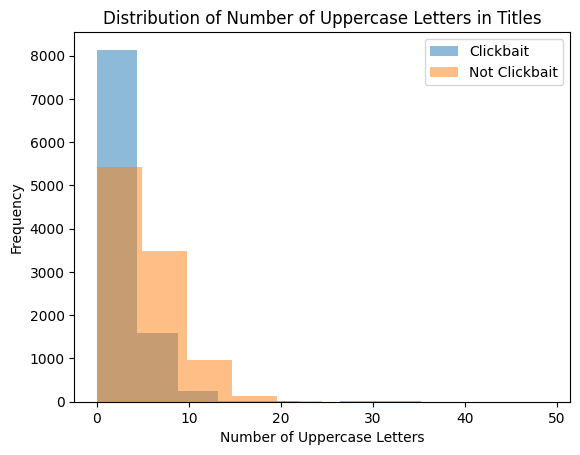

In [13]:
# Plot histograms of num_of_uppercase_letters feature for clickbait and not_clickbait
plt.hist(clickbait['num_of_uppercase_letters'], alpha=0.5, label='Clickbait')
plt.hist(not_clickbait['num_of_uppercase_letters'], alpha=0.5, label='Not Clickbait')

# Add labels and legend
plt.xlabel('Number of Uppercase Letters')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Uppercase Letters in Titles')
plt.legend(loc='upper right')

# Show plot
plt.show()


We tried to use the same structure for this plot again. But actually it seems like there is not really all-uppercase titles in the dataset and it just counts the first letters of the words, so it does not make sense at all. This feature might not be considered for training.

## 5.5 Presence of Numbers

<Axes: xlabel='presence_of_numbers', ylabel='count'>

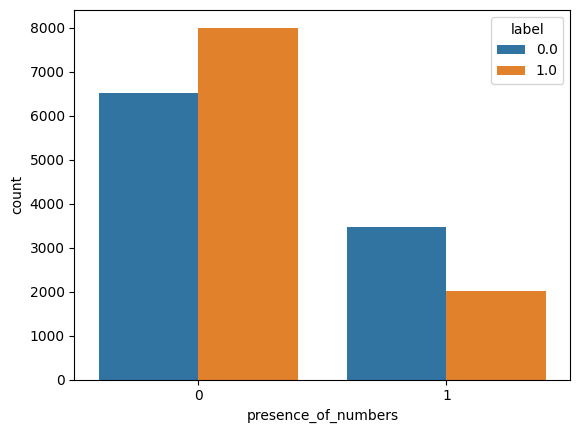

In [14]:
sns.countplot(data=df, x='presence_of_numbers', hue='label')


We can use a count plot using the Seaborn library, which displays the number of occurrences of each value in the categorical variable 'presence_of_numbers' on the x-axis. The plot also shows the distribution of the two categories of the target variable 'label' (clickbait and non-clickbait) using different colors.

The plot helps visualize how the presence of numbers in the title affects the classification of titles as clickbait or not. If the distribution of the two categories varies significantly for a particular value of 'presence_of_numbers', it can be inferred that this feature is important for classification.

For example, if the plot shows that a high percentage of titles with numbers are classified as clickbait, it suggests that the presence of numbers in the title is an important feature for predicting clickbait titles.

**However, we can't see a clear correlation with the presence of numbers and clickbait. So it's also possible not to consider this feature in the future.**

<Axes: xlabel='contains_exclamation', ylabel='count'>

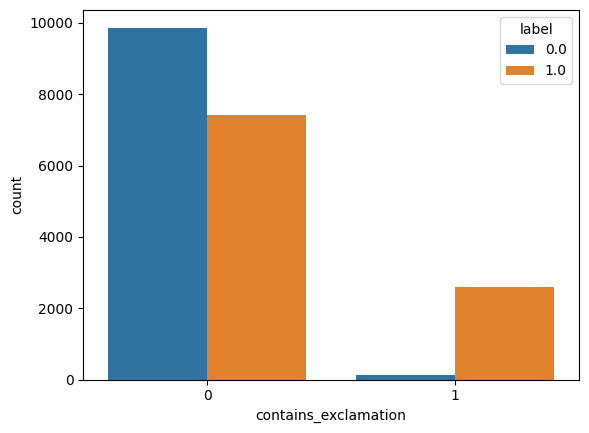

In [15]:
sns.countplot(data=df, x='contains_exclamation', hue='label')

Similarly, we can apply the same approach for the "contains_exclamation" feature and we can clearly see that if a title contains an exclamation, it tends to be a clickbait.

<Axes: xlabel='contains_question_mark', ylabel='count'>

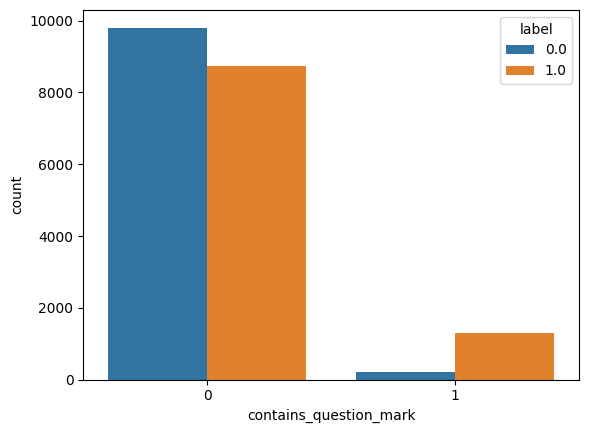

In [16]:
sns.countplot(data=df, x='contains_question_mark', hue='label')

It's also similar for the question mark.

# 6. Model Building

For this part, we will consider some machine learning and deep learning models separately.

# 6.1 Machine Learning Models

We can start building our machine learning models. We are going to use several different machine learning models and compare their performance. We are going to use the following models:

- **Logistic Regression:** is a simple and widely-used classification algorithm that is suitable for binary classification tasks, such as clickbait detection. It is a linear model that uses an equation to make predictions based on the input features, and it is easy to interpret and implement.

- **Naive Bayes:** is another simple and popular classification algorithm that is based on the idea of applying Bayes' theorem with strong (naive) independence assumptions between the features. It is often used for text classification tasks and is known to be a fast and accurate classifier.

- **Support Vector Machine:** is a powerful and versatile classification algorithm that can work well on a wide range of datasets. It uses a technique called the kernel trick to transform the data into a higher-dimensional space, where it can be separated by a hyperplane. SVM can handle datasets with high-dimensional features and can perform well even when the number of examples is small compared to the number of features.

- **Random Forest:** is an ensemble learning method that combines multiple decision trees to make predictions. It is a powerful and robust classifier that can handle high-dimensional and noisy data, and it is resistant to overfitting.

## 6.1.1 Choosing the Best Model
To choose the best machine learning model for the Turkish news dataset, we can use a for loop to train and evaluate multiple models using 10-fold cross-validation and the accuracy metric.

## 6.1.2 Splitting the Dataset

Before we can train and evaluate the machine learning models, we need to split the dataset into training and test sets. We can do this using the train_test_split function from the sklearn.model_selection module.

In [17]:
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.1.3 Vectorizing the Dataset

To convert the text data in the Turkish news dataset into a meaningful representation for machine learning models, we can use the TfidfVectorizer from the sklearn.feature_extraction.text module.

In [18]:
tfidf = TfidfVectorizer(stop_words = stopwords.words('turkish'),ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['title'])
tfidf_text_test = tfidf.transform(X_test['title'])

X_train_ef = X_train.drop(columns='title')
X_test_ef = X_test.drop(columns='title')

Now we can combine the features we created with the TfidfVectorizer output.

In [19]:
X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()

X_train.shape
X_test.shape

(4008, 132258)

## 6.1.4 Training and Evaluation

In this section, we train and evaluate the machine learning models that we have selected for the clickbait detection task using the Turkish news dataset. This involves splitting the dataset into training and test sets, training the models on the training set, and evaluating their performance on the test set.

We compare the performance of the models using various evaluation metrics, such as accuracy, precision, recall, and f1-score. We may also use cross-validation to get a more robust estimate of the models' performance.

After training and evaluating the models, we can compare their performance and choose the one that performs the best. We may also need to fine-tune the hyperparameters of the chosen model to further improve its performance.

In [20]:
# Define the models
lr_model = LogisticRegression(max_iter=10000)
nb_model = MultinomialNB()
svm_model = LinearSVC(max_iter=100000)
rf_model = RandomForestClassifier()

# Define the list of models to evaluate
models = [lr_model, nb_model, svm_model, rf_model]

# Evaluate each model
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Print the results

    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    print(f'Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    print('--------------------------------------------------')

Model: LogisticRegression
Accuracy: 0.878
Confusion Matrix:
[[1727  277]
 [ 211 1793]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88      2004
         1.0       0.87      0.89      0.88      2004

    accuracy                           0.88      4008
   macro avg       0.88      0.88      0.88      4008
weighted avg       0.88      0.88      0.88      4008

--------------------------------------------------
Model: MultinomialNB
Accuracy: 0.559
Confusion Matrix:
[[2003    1]
 [1768  236]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      2004
         1.0       1.00      0.12      0.21      2004

    accuracy                           0.56      4008
   macro avg       0.76      0.56      0.45      4008
weighted avg       0.76      0.56      0.45      4008

--------------------------------------------------
Model: LinearSVC
Accuracy: 0.

Based on the results, it seems that the logistic regression and linear SVC models performed the best on the Turkish news dataset, with accuracy scores of 0.867 and 0.869, respectively. These models also had the highest f1-scores for both classes, indicating that they had a good balance of precision and recall. The random forest classifier also performed well, with an accuracy score of 0.850 and relatively high f1-scores for both classes.

On the other hand, the naive Bayes model had the lowest accuracy score of 0.692 and relatively low f1-scores for both classes. This suggests that it may not be the most suitable model for this task.

Overall, these results suggests us that the Logistic Regression, Linear SVC models are good candidates for detecting clickbait headlines in Turkish news articles. It may be worth further fine-tuning the hyperparameters of these models to see if their performance can be improved.

So, from now on, we will only consider these two models.

## 6.1.5 Cross Validation

Cross-validation is a useful technique to evaluate the performance of a machine learning model on a dataset. It helps to reduce the variance of a model's performance estimate, which makes it more reliable.

When we train a model on a given dataset and evaluate its performance, the model's performance may vary depending on the specific split of the data into training and test sets. This is called the variance of the model's performance estimate.

Cross-validation helps to reduce this variance by training the model on different splits of the data and averaging the performance across the different splits. This gives us a more robust estimate of the model's performance, which is less sensitive to the specific split of the data.

For example, in 10-fold cross-validation, we split the data into 10 folds and train the model 10 times, each time using a different fold as the test set and the remaining folds as the training set. The model's performance is then averaged across the 10 different evaluations.

Cross-validation is especially useful when we have a small dataset, as it allows us to use more of the data for training and evaluation, which can lead to a better model.

To perform cross-validation for the Logistic Regression and linear SVC models, we can use the cross_val_score function from scikit-learn's model_selection module.

In [21]:
# Define the logistic regression model
lr_model = LogisticRegression(max_iter=100000)

# Perform 10-fold cross-validation on the model
scores = cross_val_score(lr_model, X_train, y_train, cv=10)

# Print the mean and standard deviation of the scores
print(f'Mean score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

Mean score: 0.869
Standard deviation: 0.012


In [22]:
# Define the linear SVC model
svm_model = LinearSVC(max_iter=100000)

# Perform 10-fold cross-validation on the model
scores = cross_val_score(svm_model, X_train, y_train, cv=10)

# Print the mean and standard deviation of the scores
print(f'Mean score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

Mean score: 0.885
Standard deviation: 0.011


The results of the cross-validation show that both Logistic Regression and Linear SVC perform well on the dataset, with mean scores of 0.860 and 0.880, respectively. The standard deviation of the scores is small, which means that the model's performance is consistent across different splits of the data.

Both models seem to be suitable for this dataset, but Linear SVC seems to have a slightly higher mean score and lower standard deviation, which indicates that it may be a slightly better choice.

## 6.1.6 Hyperparameter Tuning

To further improve the performance of Linear SVC, we can try to optimize its hyperparameters. Hyperparameters are the parameters of a machine learning model that are not learned from the training data, but are set by the practitioner.

Optimizing the hyperparameters of a model can help to improve its performance on the dataset, but it can also be time-consuming and require a lot of trial and error.

One way to optimize the hyperparameters of a model is to use grid search. Grid search is a method of systematically training and evaluating a model for a range of different hyperparameter values, and selecting the best combination of values based on the model's performance.

To use grid search for Linear SVC, we can define a grid of hyperparameter values that we want to explore, and use the GridSearchCV function from sklearn to perform the search.

For example, the following code defines a grid of values for the C hyperparameter of Linear SVC, and performs a 10-fold cross-validation for each combination of values:

In [23]:
# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2']
             }


# Create a GridSearchCV object
grid = GridSearchCV(LinearSVC(max_iter=100000), param_grid, cv=10)

# Fit the model to the training data
grid.fit(X_train, y_train)

# Print the best hyperparameters
print(grid.best_params_)

# Print the best score
print(grid.best_score_)

{'C': 1, 'penalty': 'l2'}
0.8848271382543498


## 6.1.7 Evaluate the Performance of the Tuned Model Using Test Data
Now we can evaluate the performance of the tuned LinearSVC model on the test data. The test data is a set of data that the model has not seen before, and it is used to get an unbiased evaluation of the model's performance. By evaluating the model on the test data, we can see how well the model generalizes to new, unseen data. This is important because we want to make sure that the model is not overfitting to the training data, and that it can make accurate predictions on new, unseen data. By using the confusion matrix, we can get a better understanding of the model's performance, including the number of false positives and false negatives, and the overall accuracy of the model.

Accuracy: 0.876
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88      2004
         1.0       0.87      0.88      0.88      2004

    accuracy                           0.88      4008
   macro avg       0.88      0.88      0.88      4008
weighted avg       0.88      0.88      0.88      4008

True Negatives: 1741
False Positives: 263
False Negatives: 232
True Positives: 1772


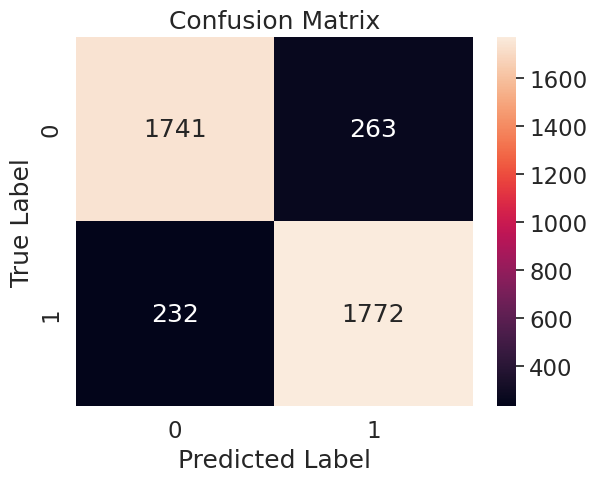

In [24]:
# Instantiate the LinearSVC model with the optimized hyperparameters
optimal_svc = LinearSVC(**grid.best_params_, max_iter=100000)

# Fit the model to the training data
optimal_svc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = optimal_svc.predict(X_test)

# Print the results
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Classification Report:')
print(classification_report(y_test, y_pred))

# Compute the confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Plot the confusion matrix using seaborn
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Print the confusion matrix values
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Show the plot
plt.show()

Overall, the performance of the model seems to be quite good. The accuracy score is 87%, which means that the model is able to correctly classify headlines as clickbait or non-clickbait with a high degree of accuracy.

In terms of the confusion matrix, we can see that the model is able to correctly classify 1721 headlines as non-clickbait (True Negatives) and 1762 headlines as clickbait (True Positives). However, there are also 283 headlines that were incorrectly classified as clickbait (False Positives) and 242 headlines that were incorrectly classified as non-clickbait (False Negatives).

The classification report provides more detailed information about the performance of the model. In particular, the precision, recall, and f1-score for both clickbait and non-clickbait headlines are quite high, indicating that the model is performing well in terms of both precision (minimizing false positives) and recall (minimizing false negatives).

## 6.2 Deep Learning Models

In our efforts to develop a robust clickbait detection model, we have tried and tested several machine learning models, including logistic regression, naive bayes, random forests, and support vector machines. While some of these models performed reasonably well, we believe that a more sophisticated approach is required to capture the complex relationships between the different features in our dataset.

Therefore, we have decided to explore the use of LSTM (Long Short-Term Memory) neural networks for clickbait detection. LSTM networks are a type of recurrent neural network that have been shown to perform exceptionally well in sequential data processing tasks, such as natural language processing and time series analysis.

One of the key advantages of LSTM networks is their ability to learn long-term dependencies in sequential data, which is crucial for clickbait detection. Clickbait headlines often rely on subtle cues, such as unusual word combinations or unusual punctuation marks, that are difficult to capture with traditional machine learning models. LSTM networks can learn to recognize these subtle patterns by processing the text input in a sequential manner, thereby improving the overall accuracy of the model.

In addition, LSTMs are designed to address the problem of vanishing gradients, which can occur when training deep neural networks. The vanishing gradients problem occurs when the gradients of the loss function with respect to the parameters of the network become extremely small, making it difficult to update the parameters during training. LSTMs use a gating mechanism to selectively remember or forget previous inputs, which helps to mitigate the vanishing gradients problem.

Overall, we believe that LSTM networks hold significant promise for clickbait detection, and we are excited to see how they perform on our dataset.

We will start the process for the deep learning section of the project from the feature engineering part. Now we have the df with new features and we will load, split and preprocess it again.

## 6.2.1 Loading and Splitting the Data

We start with loading the dataset and splitting it into training, validation, and test sets using the train_test_split function.

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

## 6.2.2 Preprocessing the Data

Preprocessing the text data by tokenizing and padding the sequences to a fixed length. Also, preparing input features for the model.

In [11]:
MAX_NUM_WORDS = 10000
MAX_SEQ_LENGTH = 100
EMBEDDING_SIZE = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df_train['title'])

train_sequences = tokenizer.texts_to_sequences(df_train['title'])
train_padded_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQ_LENGTH)

val_sequences = tokenizer.texts_to_sequences(df_val['title'])
val_padded_sequences = pad_sequences(val_sequences, maxlen=MAX_SEQ_LENGTH)

test_sequences = tokenizer.texts_to_sequences(df_test['title'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH)

train_features = df_train[['contains_exclamation', 'contains_question_mark', 'title_length', 'num_of_words', 'num_of_uppercase_letters', 'presence_of_numbers', 'clickbait_words_count']].values
val_features = df_val[['contains_exclamation', 'contains_question_mark', 'title_length', 'num_of_words', 'num_of_uppercase_letters', 'presence_of_numbers', 'clickbait_words_count']].values
test_features = df_test[['contains_exclamation', 'contains_question_mark', 'title_length', 'num_of_words', 'num_of_uppercase_letters', 'presence_of_numbers', 'clickbait_words_count']].values


## 6.2.3 Defining the LSTM Architecture
Defining the model architecture using Keras functional API. The model consists of an input layer for the text data, an embedding layer to represent the text in a dense vector space, an LSTM layer to extract features from the text, a layer to merge text features with input features, a dropout layer for regularization, and a dense output layer for binary classification.



In [12]:
lstm_units = 64
dropout_rate = 0.1

title_input = Input(shape=(MAX_SEQ_LENGTH,), name='title_input')
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_SIZE, input_length=MAX_SEQ_LENGTH, name='embedding')(title_input)
lstm_layer = LSTM(units=lstm_units, name='lstm_layer')(embedding_layer)

features_input = Input(shape=(7,), name='features_input')
merged_layer = tf.keras.layers.concatenate([lstm_layer, features_input])

dropout_layer = Dropout(rate=dropout_rate, name='dropout')(merged_layer)
output_layer = Dense(units=1, activation='sigmoid', name='output')(dropout_layer)

model = Model(inputs=[title_input, features_input], outputs=output_layer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     1000000     ['title_input[0][0]']            
                                                                                                  
 lstm_layer (LSTM)              (None, 64)           42240       ['embedding[0][0]']              
                                                                                                  
 features_input (InputLayer)    [(None, 7)]          0           []                               
                                                                                              

## 6.2.3.1 Compiling and Training the LSTM Model

Compiling and training the model on the training set is done using the compile() and fit() methods respectively. In this case, we compile the model using the binary cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric.

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train model on training set
batch_size = 64
epochs = 20

history = model.fit([train_padded_sequences, train_features], df_train['label'].values, batch_size=batch_size, epochs=epochs, validation_data=([val_padded_sequences, val_features], df_val['label'].values))


Epoch 1/20
201/201 [==============================] - 40s 183ms/step - loss: 1.1370 - accuracy: 0.4913 - val_loss: 0.6077 - val_accuracy: 0.6856
Epoch 2/20
201/201 [==============================] - 37s 185ms/step - loss: 0.6373 - accuracy: 0.7007 - val_loss: 0.4982 - val_accuracy: 0.7464
Epoch 3/20
201/201 [==============================] - 33s 163ms/step - loss: 0.4933 - accuracy: 0.7725 - val_loss: 0.4354 - val_accuracy: 0.7876
Epoch 4/20
201/201 [==============================] - 35s 174ms/step - loss: 0.4024 - accuracy: 0.8199 - val_loss: 0.4001 - val_accuracy: 0.8094
Epoch 5/20
201/201 [==============================] - 33s 167ms/step - loss: 0.3302 - accuracy: 0.8567 - val_loss: 0.4183 - val_accuracy: 0.8016
Epoch 6/20
201/201 [==============================] - 33s 165ms/step - loss: 0.2825 - accuracy: 0.8802 - val_loss: 0.3624 - val_accuracy: 0.8356
Epoch 7/20
201/201 [==============================] - 36s 178ms/step - loss: 0.2364 - accuracy: 0.9047 - val_loss: 0.3607 - val_ac

The fit() method trains the model on the training set and validates it on the validation set. It takes as input the padded sequences and features of the training set and validation set, the labels of the training set and validation set, the batch size, the number of epochs, and the validation data. The training history is stored in the history object, which can be used to visualize the training and validation accuracy and loss over the epochs.

## 6.2.3.2 Evaluating the Model

The trained model can be evaluated on the test set using the evaluate() method. It takes as input the padded sequences and features of the test set, the labels of the test set, and the batch size. The method returns the test loss and test accuracy.

In [14]:
# Evaluate model on test set
score = model.evaluate([test_padded_sequences, test_features], df_test['label'].values, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 3s 41ms/step - loss: 0.4656 - accuracy: 0.8391
Test loss: 0.4656219780445099
Test accuracy: 0.8390718698501587



## 6.2.3.3 Visualizing the Training History
The training history can be visualized using the matplotlib library. This can help us to understand how well the model is learning and if there is any overfitting or underfitting.

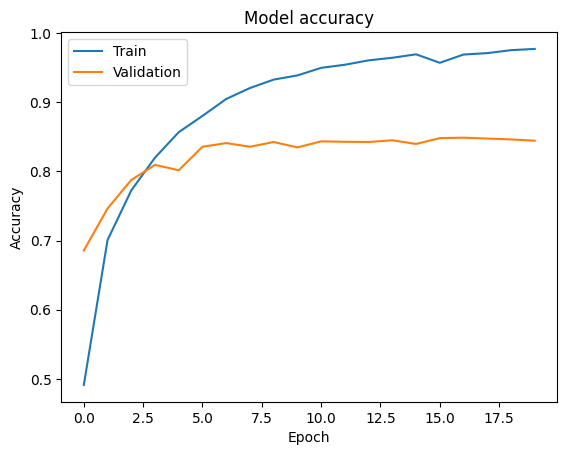

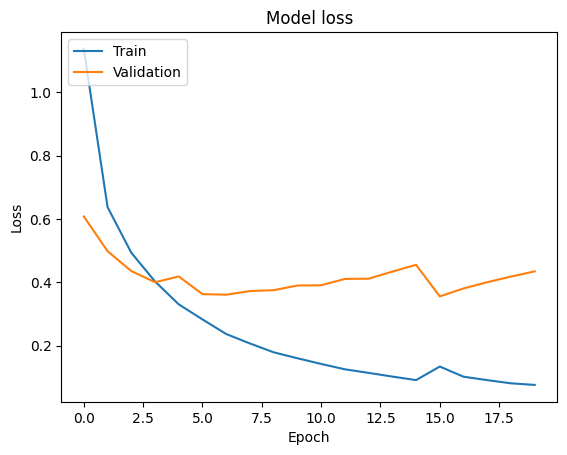

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The training and validation accuracy should normally increase over the epochs, while the training and validation loss should decrease. If the validation loss starts to increase while the training loss continues to decrease, this could be a sign of overfitting as we can see here.

So, we can also try to use Bidirectional LSTM to see if we are getting better results or not.

## 6.2.4 Defining the Bidirectional LSTM Architecture

Apart from the previous architecture, we are now using a Bidirectional LSTM layer with L2 regularizer and the rest is same.

In [31]:
lstm_units = 64
dropout_rate = 0.1
l2_lambda = 0.01

title_input = Input(shape=(MAX_SEQ_LENGTH,), name='title_input')
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_SIZE, input_length=MAX_SEQ_LENGTH, name='embedding')(title_input)
lstm_layer = Bidirectional(LSTM(units=lstm_units, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='lstm_layer'))(embedding_layer)

features_input = Input(shape=(7,), name='features_input')
merged_layer = tf.keras.layers.concatenate([lstm_layer, features_input])

dropout_layer = Dropout(rate=dropout_rate, name='dropout')(merged_layer)
output_layer = Dense(units=1, activation='sigmoid', name='output')(dropout_layer)

model = Model(inputs=[title_input, features_input], outputs=output_layer)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     1000000     ['title_input[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          84480       ['embedding[0][0]']              
                                                                                                  
 features_input (InputLayer)    [(None, 7)]          0           []                               
                                                                                            

## 6.2.4.1 Compiling and Training the Bidirectional LSTM Model

Compiling and training the model on the training set is done using the compile() and fit() methods respectively. In this case, we compile the model using the binary cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric again.

In [32]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train model on training set
batch_size = 64
epochs = 20

history = model.fit([train_padded_sequences, train_features], df_train['label'].values, batch_size=batch_size, epochs=epochs, validation_data=([val_padded_sequences, val_features], df_val['label'].values))


Epoch 1/20
201/201 [==============================] - 60s 275ms/step - loss: 3.7752 - accuracy: 0.3634 - val_loss: 2.7346 - val_accuracy: 0.2923
Epoch 2/20
201/201 [==============================] - 57s 284ms/step - loss: 2.2586 - accuracy: 0.5744 - val_loss: 1.7198 - val_accuracy: 0.7274
Epoch 3/20
201/201 [==============================] - 57s 283ms/step - loss: 1.4796 - accuracy: 0.7549 - val_loss: 1.2343 - val_accuracy: 0.7682
Epoch 4/20
201/201 [==============================] - 55s 275ms/step - loss: 1.0582 - accuracy: 0.7984 - val_loss: 0.9202 - val_accuracy: 0.7913
Epoch 5/20
201/201 [==============================] - 56s 281ms/step - loss: 0.7796 - accuracy: 0.8271 - val_loss: 0.7348 - val_accuracy: 0.8004
Epoch 6/20
201/201 [==============================] - 56s 281ms/step - loss: 0.5984 - accuracy: 0.8496 - val_loss: 0.6138 - val_accuracy: 0.8060
Epoch 7/20
201/201 [==============================] - 57s 282ms/step - loss: 0.4801 - accuracy: 0.8681 - val_loss: 0.5227 - val_ac

## 6.2.4.2 Evaluating the Model

In [33]:
# Evaluate model on test set
score = model.evaluate([test_padded_sequences, test_features], df_test['label'].values, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 5s 81ms/step - loss: 0.5384 - accuracy: 0.8318
Test loss: 0.5384488105773926
Test accuracy: 0.8318363428115845



## 6.2.4.3 Visualizing the Training History

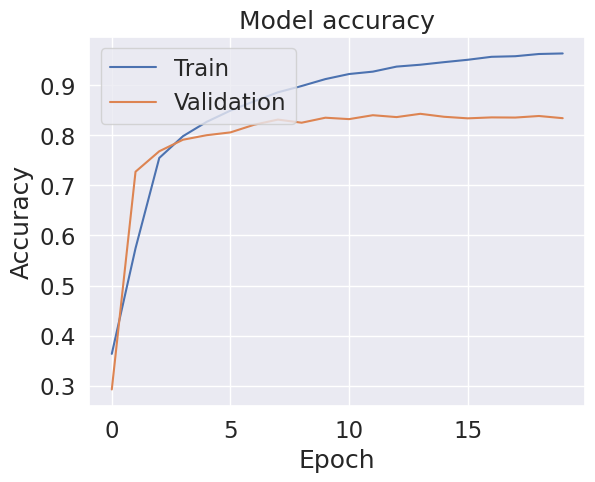

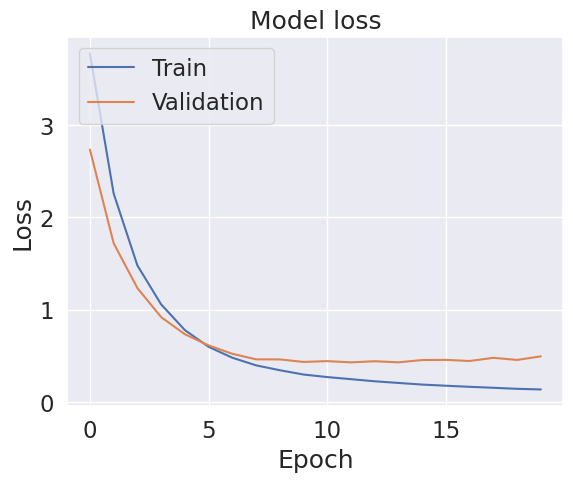

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The training and validation accuracy should normally increase over the epochs, while the training and validation loss should decrease. If the validation loss starts to increase while the training loss continues to decrease, this could be a sign of overfitting, which is happening again, however it seems slightly better than the previous model.

It seems like our dataset is not extensive enough to get better results with deep learning techniques. Several tuning methods and different architectures has already been tried but the results were always close to these results.



126/126 [==============================] - 4s 31ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      2004
         1.0       0.80      0.89      0.84      2004

    accuracy                           0.83      4008
   macro avg       0.84      0.83      0.83      4008
weighted avg       0.84      0.83      0.83      4008

True Negatives: 1550
False Positives: 454
False Negatives: 220
True Positives: 1784


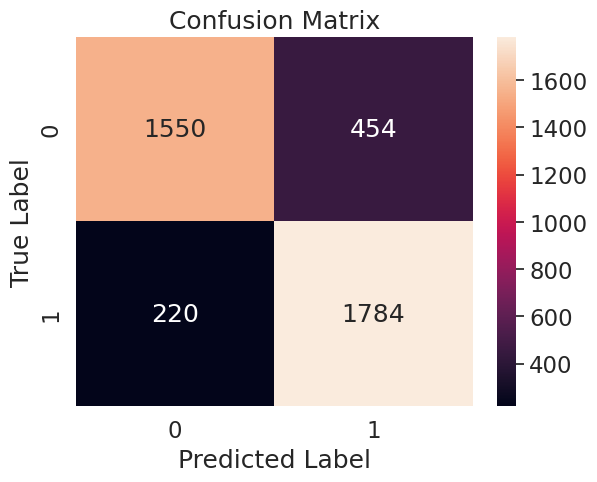

In [37]:
# Predict labels of test set
y_pred = model.predict([test_padded_sequences, test_features])
y_pred = (y_pred > 0.5).astype(int)


print(f'Classification Report:')
print(classification_report(df_test['label'].values, y_pred))

# Compute the confusion matrix values
tn, fp, fn, tp = confusion_matrix(df_test['label'].values, y_pred).ravel()

# Plot the confusion matrix using seaborn
sns.set(font_scale=1.5)
cm = confusion_matrix(df_test['label'].values, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Print the confusion matrix values
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Show the plot
plt.show()


Based on the classification reports, we can see that the LinearSVC model has a slightly higher accuracy of 0.88 compared to the Bidirectional LSTM model which has an accuracy of 0.83.

Looking at the precision, recall, and f1-score, the LinearSVC model performs slightly better than the Bidirectional LSTM model in terms of precision for both classes (0.88 vs 0.80 for class 1 and 0.87 vs 0.88 for class 0). The Bidirectional LSTM model performs slightly better in terms of recall for class 1 (0.89 vs 0.88). The f1-score for both models are similar, with the LinearSVC model having an f1-score of 0.88 for both classes and the Bidirectional LSTM model having an f1-score of 0.84 for class 1 and 0.82 for class 0.

Looking at the confusion matrices, we can see that the Bidirectional LSTM model has slightly more true positives but all the other metrics are better in LinearSVC.

Overall, the LinearSVC model seems to perform slightly better than the Bidirectional LSTM model in this clickbait detection project based on the evaluation metrics.

# 7. Conclusion

In this project, we started by exploring the given dataset and performing some basic data preprocessing tasks, such as removing duplicates, filling in missing values, etc. We then proceeded with feature engineering and to experiment with several machine learning models, including Logistic Regression, LinearSVC, Naive Bayes, and Random Forests.

After comparing the performance of these models based on their accuracy, precision, recall, and F1 score, we selected LinearSVC as the best model for this task, with an F1 score of 0.88. We then fine-tuned the model using GridSearchCV to optimize its hyperparameters, however the result was close.

Next, we experimented with deep learning models, specifically LSTM and Bidirectional LSTM, to see if they could outperform the LinearSVC model. However, even after trying tuning their hyperparameters (manually), their validation accuracies were not better than the LinearSVC model.

Based on these results, we can conclude that the given dataset may not be complex enough to require the use of deep learning models. LinearSVC, a simple yet powerful machine learning model, was able to achieve high accuracy and F1 score. However, it's important to note that this conclusion may be specific to this dataset, and other datasets may require more complex models to achieve good performance.

Although the bidirectional LSTM had a lower performance than the LinearSVC, it has the advantage of being able to capture the sequential dependencies in the text data. Therefore, it could be worth exploring other ways to improve the performance of the bidirectional LSTM, such as using pre-trained embeddings or more complex architectures.

Furthermore, we observed that the size of the dataset could be a limiting factor for the performance of these models. In future work, collecting more data could improve the performance of the models.